# Regression on "p_outlier"

This small tutorial illustrates how we can define a regression directly on the `p_outlier` parameter.
The way we define the regression follows the basic pattern we establish in the `include` argument.

### Load Modules

In [1]:
import hssm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

### Simulate some data

In [2]:
# synth data
n_participants = 10
conditions = ['switch', 'noswitch','someswitch']
n_samples_per_condition = 250

v_by_participant = np.random.normal(loc=0.0, scale=0.5, size=n_participants)
v_displacement_by_condition = {'switch': 1.0, 'noswitch': 0., 'someswitch': -1.0}
a_true = 1.0
z_true = 0.5
t_true = 0.5
dfs = []

for participant in range(n_participants):
    for condition in conditions:
        tmp_df = hssm.simulate_data(model = 'ddm', theta = dict(v = v_by_participant[participant] + v_displacement_by_condition[condition],
                                                                a = a_true,
                                                                z = z_true,
                                                                t = t_true), size = n_samples_per_condition)
        tmp_df['true_v'] = v_by_participant[participant] + v_displacement_by_condition[condition]
        tmp_df['true_a'] = a_true
        tmp_df['true_z'] = z_true
        tmp_df['true_t'] = t_true
        tmp_df['participant_id'] = str(participant)
        tmp_df['trialtype'] = condition
        dfs.append(tmp_df)


data_df = pd.concat(dfs).reset_index(drop=True)

### Inject Uniform noise into `rts` to simulate outliers

In [3]:
# Inject noise
p_outlier_noise = np.random.uniform(0, 0.15, size = n_participants)
for i in range(n_participants):
    # Get indices of trials to inject noise
    p_outlier_indices = np.random.choice(data_df[data_df['participant_id'] == str(i)].index,
                                         size = int(p_outlier_noise[i] * \
                                                    len(data_df[data_df['participant_id'] == str(i)])),
                                         replace = False)
    # Inject noise
    data_df.loc[p_outlier_indices, "rt"] = np.random.uniform(low = 0., high = 20., 
                                                             size = data_df.loc[p_outlier_indices, "rt"].shape)

### Define and sample from HSSM model 

In [4]:
test_model_1_C = hssm.HSSM(data_df,
          model = "ddm",
          loglik_kind = "approx_differentiable",
          include = [{"name": "v", "formula": "v ~ 0 + (1 + C(trialtype) |participant_id)"}],
          p_outlier = {"formula": "p_outlier ~ 1 + (1|C(participant_id))",
                       "prior": {"Intercept": {"name": "Normal", "mu": 0, "sigma": 1}},
                       "link": "logit"
                       },
         )

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


In [ ]:
test_model_1_C.sample(
    sampler="numpyro",  # type of sampler to choose, 'numpyro', 'blackjax' or default pymc nuts sampler
    cores=2,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)

Using default initvals. 



/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1000/1000 [11:19<00:00,  1.47it/s, 63 steps of size 1.12e-01. acc. prob=0.90]  
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1000/1000 [00:06<00:00, 146.11it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [6]:
# Add tiral-wise parameters to idata (since we define p_outlier as a regression)
test_model_1_C.add_likelihood_parameters_to_idata(inplace=True)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot Results

In [7]:
# Define output dataframe for plotting
data_df['p_outlier'] = test_model_1_C.traces.posterior.p_outlier.mean(dim = ['chain', 'draw'])
data_df[['hdi_higher', 'hdi_lower']] = az.hdi(test_model_1_C.traces.posterior.p_outlier, hdi_prob = 0.95).to_dataframe()\
                                        .reset_index().pivot(index = '__obs__', columns = 'hdi', values = 'p_outlier')

In [8]:
grouped_df = data_df.groupby('participant_id')[['p_outlier', 'hdi_higher', 'hdi_lower']].mean()
grouped_df['p_outlier_gt'] = p_outlier_noise

In [9]:
grouped_df

,p_outlier,hdi_higher,hdi_lower,p_outlier_gt
participant_id,,,,
0,0.032498,0.050727,0.019399,0.022874
1,0.011941,0.022223,0.002686,0.004256
2,0.151013,0.181665,0.121329,0.128981
3,0.023265,0.035896,0.010958,0.016532
4,0.153351,0.183267,0.127115,0.136520
5,0.104289,0.131790,0.077138,0.080146
6,0.165424,0.196696,0.133180,0.129931
7,0.162412,0.193465,0.128042,0.146699
8,0.044307,0.063794,0.026451,0.034605


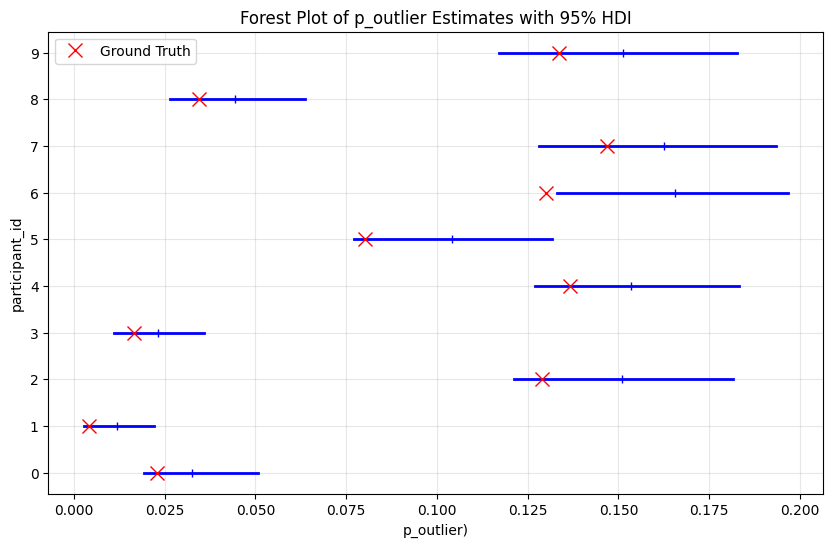

In [10]:
# Create forest plot
plt.figure(figsize=(10, 6))

# Plot HDI bands for each participant
for idx, row in grouped_df.iterrows():
    plt.plot([row['hdi_lower'], row['hdi_higher']], [idx, idx], 'b-', linewidth=2)
    plt.plot(row['p_outlier'], idx, 'b|')  # Plot mean point

# Plot ground truth values as red crosses
plt.plot(grouped_df['p_outlier_gt'], grouped_df.index, 'rx', label='Ground Truth', markersize=10)

plt.xlabel('p_outlier)')
plt.ylabel('participant_id')
plt.title('Forest Plot of p_outlier Estimates with 95% HDI')
plt.legend()
plt.grid(True, alpha=0.3)